In [125]:
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob
import pandas as pd
from tqdm import tqdm
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model
import zipfile

In [126]:
zip_dir = '/content/drive/MyDrive/DataSet/satalite_data.zip'
zip_ref = zipfile.ZipFile(zip_dir, 'r')
zip_ref.extractall('/content/sample_data')
zip_ref.close()

In [127]:
main_dir = '/content/sample_data/satalite data/data'
images_dir = os.path.join(main_dir, 'images')
labels_dir = os.path.join(main_dir, 'labels')

In [128]:
os.listdir(main_dir)

['images', 'labels']

In [129]:
for dir, dirname, filename in os.walk(images_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

print('-'*100)

for dir, dirname, filename in os.walk(labels_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

Found 0 directories and 306 images in /content/sample_data/satalite data/data/images
----------------------------------------------------------------------------------------------------
Found 0 directories and 456 images in /content/sample_data/satalite data/data/labels


In [130]:
allowed_indices = set(str(i) + ".png" for i in range(0, 306))
for filename in os.listdir(labels_dir):
    if filename.endswith('.png'):
        if filename not in allowed_indices:
            os.remove(os.path.join(labels_dir, filename))
            print(f"Deleted: {filename}")
    else:
        # Optionally remove non-jpg images too
        os.remove(os.path.join(labels_dir, filename))
        print(f"Deleted (non-jpg): {filename}")

Deleted: 32_11.png
Deleted: 57_45.png
Deleted: 111_121.png
Deleted: 29_186.png
Deleted: 101_89.png
Deleted: 118_125.png
Deleted: 58_114.png
Deleted: 17_60.png
Deleted: 38_68.png
Deleted: 27_290.png
Deleted: 76_92.png
Deleted: 65_203.png
Deleted: 12_286.png
Deleted: 50_263.png
Deleted: 46_55.png
Deleted: 98_253.png
Deleted: 104_20.png
Deleted: 85_117.png
Deleted: 49_64.png
Deleted: 103_225.png
Deleted: 30_143.png
Deleted: 95_221.png
Deleted: 107_59.png
Deleted: 150_243.png
Deleted: 84_76.png
Deleted: 59_132.png
Deleted: 99_170.png
Deleted: 5_275.png
Deleted: 112_78.png
Deleted: 48_12.png
Deleted: 71_120.png
Deleted: 34_239.png
Deleted: 70_268.png
Deleted: 53_43.png
Deleted: 119_222.png
Deleted: 61_206.png
Deleted: 121_142.png
Deleted: 9_202.png
Deleted: 77_61.png
Deleted: 106_267.png
Deleted: 20_283.png
Deleted: 130_256.png
Deleted: 66_22.png
Deleted: 79_161.png
Deleted: 16_229.png
Deleted: 94_119.png
Deleted: 143_183.png
Deleted: 43_149.png
Deleted: 139_108.png
Deleted: 117_97.png
Dele

In [131]:
def display_image_and_mask(img_path, mask_path):
    # Use tifffile to read the image
    img = tif.imread(img_path)
    mask = Image.open(mask_path)

    # Convert the image to a displayable format (e.g., uint8)
    # Assuming the TIFF image is multi-channel and needs to be converted to RGB or grayscale
    if img.ndim == 3 and img.shape[-1] > 3: # Assuming multi-channel image
        # Take the first 3 channels as RGB, or convert to grayscale
        img = img[:,:,:3] # Or convert to grayscale if appropriate

    # Normalize image data to 0-255 if it's not already
    if img.dtype != np.uint8:
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)

    # Convert numpy array to PIL Image for displaying
    img_pil = Image.fromarray(img)


    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_pil)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

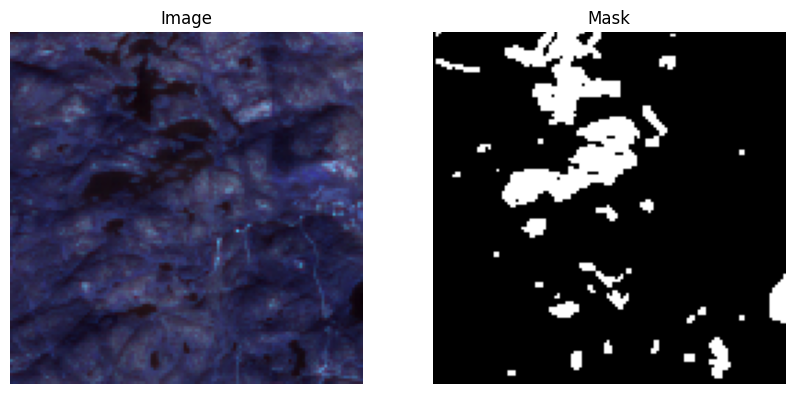

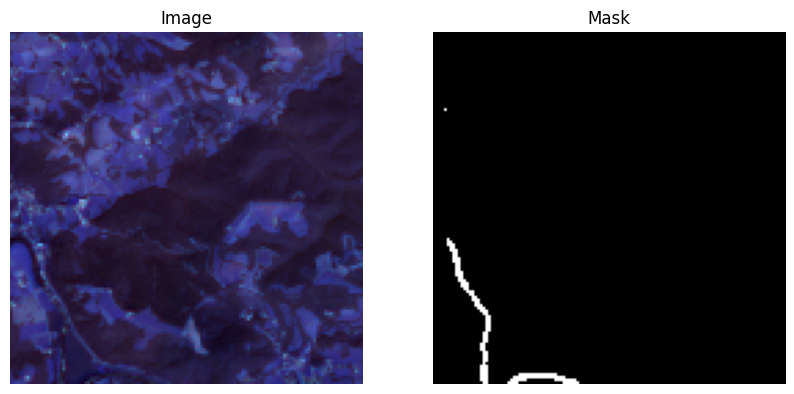

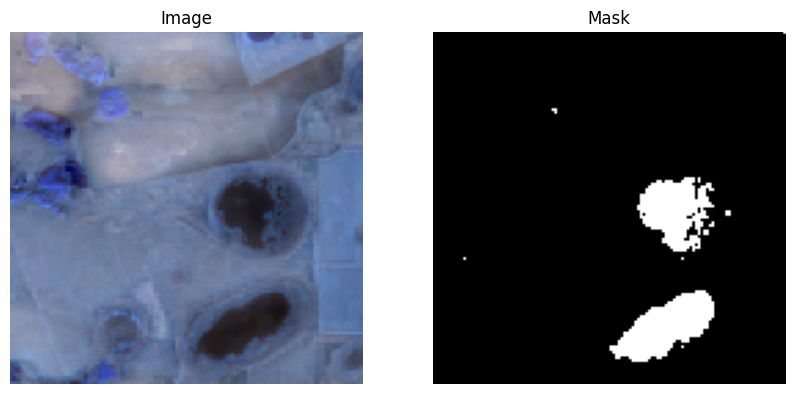

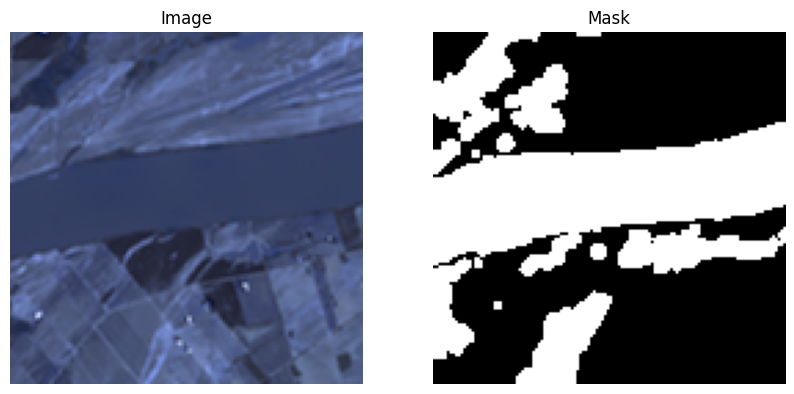

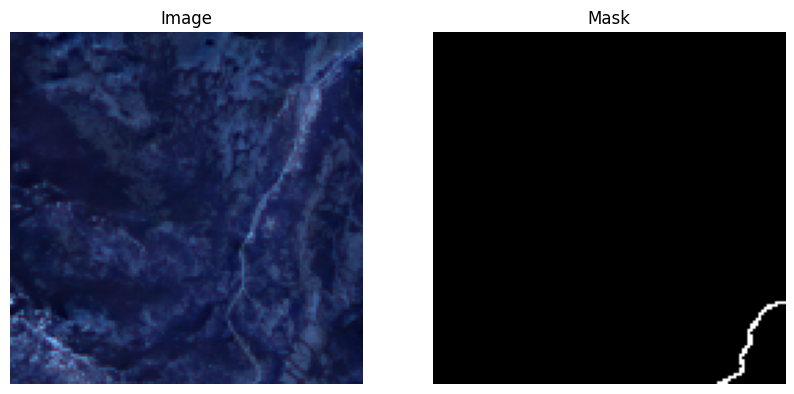

In [132]:
train_img_files = sorted(os.listdir(images_dir))
train_mask_files = sorted(os.listdir(labels_dir))

# Check that the number of images matches the number of masks
if len(train_img_files) != len(train_mask_files):
    print("Error: The number of images and masks do not match!")
else:
    # Display only the first 5 image-mask pairs
    for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
        # Construct the full file paths
        img_path = os.path.join(images_dir, img_file)
        mask_path = os.path.join(labels_dir, mask_file)

        # Display the image and mask together
        display_image_and_mask(img_path, mask_path)

In [133]:
images = [os.path.join(images_dir, file) for file in os.listdir(images_dir)]
masks = [os.path.join(labels_dir, file) for file in os.listdir(labels_dir)]

data = pd.DataFrame({"image": images, "mask": masks})

train_df, val_df = train_test_split(data, train_size=0.8, random_state=123)

In [134]:
image_datagen = ImageDataGenerator(rescale=1./255)
mask_datagen = ImageDataGenerator(rescale=1./255)

def create_generator(image_generator, mask_generator, batch_size=12):
    while True:
        for (img_batch, mask_batch) in zip(image_generator, mask_generator):
            yield img_batch, mask_batch

In [135]:
train_image_generator = image_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image",
    y_col=None,
    target_size=(128, 128),
    batch_size=12,
    class_mode=None,
    color_mode='rgb',
    shuffle=True,
    seed=42
)

train_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="mask",
    y_col=None,
    target_size=(128, 128),
    batch_size=2,
    class_mode=None,
    color_mode='grayscale',
    shuffle=True,
    seed=42
)

train_generator = create_generator(train_image_generator, train_mask_generator)


Found 244 validated image filenames.
Found 244 validated image filenames.


In [136]:
val_image_generator = image_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image",
    y_col=None,
    target_size=(128, 128),
    batch_size=12,
    class_mode=None,
    color_mode='rgb',
    shuffle=False,  # Validation data should not be shuffled
    seed=42
)

val_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="mask",
    y_col=None,
    target_size=(128, 128),
    batch_size=12,
    class_mode=None,
    color_mode='grayscale',
    shuffle=False,  # Validation data should not be shuffled
    seed=42
)


Found 62 validated image filenames.
Found 62 validated image filenames.


# Task
Modify the provided Python code to work with 12-channel images instead of 3-channel images for image display, data generation, and the U-Net model architecture.

## Modify `display image and mask` function

### Subtask:
Update the function to handle and display 12-channel images appropriately.


**Reasoning**:
Modify the `display_image_and_mask` function to handle 12-channel TIFF images for display, selecting the first 3 channels as RGB for visualization.



In [137]:
def display_image_and_mask(img_path, mask_path):
    # Use tifffile to read the image
    img = tif.imread(img_path)
    mask = Image.open(mask_path)

    # Convert the image to a displayable format (e.g., uint8)
    # Assuming the TIFF image is multi-channel and needs to be converted to RGB or grayscale
    if img.ndim == 3 and img.shape[-1] > 3: # Assuming multi-channel image
        # Take the first 3 channels as RGB for displaying with matplotlib
        img_display = img[:,:,:3]
    else:
        img_display = img

    # Normalize image data to 0-255 if it's not already
    if img_display.dtype != np.uint8:
        img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min()) * 255
        img_display = img_display.astype(np.uint8)

    # Convert numpy array to PIL Image for displaying
    img_pil = Image.fromarray(img_display)

    # Plot the image and the mask side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img_pil)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

## Modify data generators

### Subtask:
Adjust the `ImageDataGenerator` and `flow_from_dataframe` calls to handle 12-channel images. This might involve changing `color_mode` or using a custom data generator if `ImageDataGenerator` does not support 12 channels directly.


**Reasoning**:
ImageDataGenerator does not directly support 12-channel images. Therefore, a custom data generator is required to read the 12-channel TIFF images. The custom generator will also handle resizing and normalization. The existing `create_generator` function can be used to combine the image and mask generators.



In [138]:
class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, image_dir, mask_dir, batch_size=12, target_size=(128, 128), shuffle=True):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.dataframe) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_ids_x = [self.dataframe.iloc[k]["image"] for k in indexes]
        list_ids_y = [self.dataframe.iloc[k]["mask"] for k in indexes]

        X = np.empty((self.batch_size, *self.target_size, 12), dtype=np.float32)
        y = np.empty((self.batch_size, *self.target_size, 1), dtype=np.float32)

        for i, (img_path, mask_path) in enumerate(zip(list_ids_x, list_ids_y)):
            img = tif.imread(img_path).astype(np.float32)
            mask = imread(mask_path, as_gray=True).astype(np.float32)

            img = resize(img, self.target_size, anti_aliasing=True)
            mask = resize(mask, self.target_size, anti_aliasing=True)

            # Normalize image data
            img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-6)

            X[i,] = img
            y[i,] = np.expand_dims(mask, axis=-1)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataframe))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

# Update generators to use the custom generator
train_generator = CustomDataGenerator(train_df, images_dir, labels_dir, batch_size=12, target_size=(128, 128), shuffle=True)
val_generator = CustomDataGenerator(val_df, images_dir, labels_dir, batch_size=12, target_size=(128, 128), shuffle=False)


**Reasoning**:
The custom data generators have been created and should now be used in the model training step.



## Modify u-net model

### Subtask:
Update the input layer of the U-Net model to accept 12 channels instead of 3.


**Reasoning**:
Update the U-Net model definition to accept 12-channel input, instantiate the model with the new input size, compile it, and print the summary.



In [139]:
def unet_model(input_size=(128, 128, 12)): # Updated input size to 12 channels
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

model = unet_model(input_size=(128, 128, 12)) # Instantiate with 12 channels
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_321 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_15[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_322 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_321[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_60    │ (None, 64, 64,    │          0 │ conv2d_322[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_323 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_60… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_324 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_323[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_61    │ (None, 32, 32,    │          0 │ conv2d_324[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_325 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_61… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_326 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_325[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_62    │ (None, 16, 16,    │          0 │ conv2d_326[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_327 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_62… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_328 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_327[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_63    │ (None, 8, 8, 512) │          0 │ conv2d_328[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_329 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_63… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_330 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_329[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_48 │ (None, 16, 16,    │  2,097,664 │ conv2d_330[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_60      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,036,929 (118.40 MB)

 Trainable params: 31,036,929 (118.40 MB)

 Non-trainable params: 0 (0.00 B)

## Train the model

### Subtask:
Run the training process with the modified data generators and model.


**Reasoning**:
The previous attempt to train the model failed because of an issue with the data generator. The custom data generator was implemented in the previous step, and now I need to run the training process using this custom generator and the updated U-Net model.



In [140]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    steps_per_epoch=len(train_df) // 12,
    validation_steps=len(val_df) // 12
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1014']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.6591 - loss: 0.6276

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_1014']
Received: inputs=Tensor(shape=(None, 128, 128, 12))
  warnings.warn(msg)


20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 410ms/step - accuracy: 0.6625 - loss: 0.6258 - val_accuracy: 0.7478 - val_loss: 0.5738
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.7389 - loss: 0.5896 - val_accuracy: 0.7478 - val_loss: 0.5667
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step - accuracy: 0.7216 - loss: 0.5936 - val_accuracy: 0.7478 - val_loss: 0.5722
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 321ms/step - accuracy: 0.7462 - loss: 0.5648 - val_accuracy: 0.7478 - val_loss: 0.5652
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - accuracy: 0.7614 - loss: 0.5549 - val_accuracy: 0.7478 - val_loss: 0.5735


In [141]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras import backend as K

# Dice Loss
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Combined BCE + Dice Loss
def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

# IoU Metric
def iou_metric(y_true, y_pred):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + 1e-7)

# U-Net Model
def unet_model(input_size=(128, 128, 12)):
    inputs = Input(input_size)

    # Encoder
    def conv_block(x, filters, dropout=0.3):
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters, (3, 3), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(dropout)(x)
        return x

    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)

    # Decoder
    def up_block(x, skip, filters, dropout=0.3):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
        x = layers.concatenate([x, skip])
        x = conv_block(x, filters, dropout)
        return x

    u6 = up_block(c5, c4, 512)
    u7 = up_block(u6, c3, 256)
    u8 = up_block(u7, c2, 128)
    u9 = up_block(u8, c1, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Compile
model = unet_model(input_size=(128, 128, 12))
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', iou_metric])
model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_340 (Conv2D) │ (None, 128, 128,  │      6,976 │ input_layer_16[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_340[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_341 (Conv2D) │ (None, 128, 128,  │     36,928 │ activation_204[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_341[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_90          │ (None, 128, 128,  │          0 │ activation_205[0… │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_64    │ (None, 64, 64,    │          0 │ dropout_90[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_342 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_64… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_342[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_343 (Conv2D) │ (None, 64, 64,    │    147,584 │ activation_206[0… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_343[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_91          │ (None, 64, 64,    │          0 │ activation_207[0… │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_65    │ (None, 32, 32,    │          0 │ dropout_91[0][0]

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [142]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]


In [145]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.7003 - iou_metric: 0.0908 - loss: 1.3146 - val_accuracy: 0.5979 - val_iou_metric: 0.1508 - val_loss: 61.9224 - learning_rate: 0.0010
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - accuracy: 0.6804 - iou_metric: 0.0804 - loss: 1.3029 - val_accuracy: 0.7460 - val_iou_metric: 0.0028 - val_loss: 63.7338 - learning_rate: 0.0010
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 397ms/step - accuracy: 0.7000 - iou_metric: 0.1541 - loss: 1.2906 - val_accuracy: 0.7349 - val_iou_metric: 0.0319 - val_loss: 1.5322 - learning_rate: 0.0010
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.6986 - iou_metric: 0.1183 - loss: 1.2741 - val_accuracy: 0.6070 - val_iou_metric: 0.1305 - val_loss: 1.3703 - learning_rate: 0.0010
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 372ms/step - accuracy: 0.7017 - iou_metric: 0.0962 - loss: 1.3096 - val_accuracy: 0.6531 - val_iou_metric: 0.1230 - val_loss: 1.3578 - learning_rate: 0.0010
Epoch 6/

In [148]:
loss, accuracy, iou = model.evaluate(val_generator, steps=5)

print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')
print(f'Validation IoU: {iou:.4f}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.7782 - iou_metric: 0.0029 - loss: 1.3026
Validation Loss: 1.3001
Validation Accuracy: 0.7485
Validation IoU: 0.0051
